In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import numpy as np
import pymcr
import matplotlib

from pymcr.mcr import McrAR
from pymcr.constraints import ConstraintNonneg, ConstraintNorm
import matplotlib.pyplot as plt


print("Python version: ", sys.version)
print("numpy version: ", np.__version__)
print("matplotlib version: ", matplotlib.__version__)
print("pymcr version: ", pymcr.__version__)

Python version:  3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]
numpy version:  1.26.3
matplotlib version:  3.8.2
pymcr version:  0.5.1


In [5]:
with open("./ethanol-mcr.npz", "rb") as ethanol_mcr_file:
    ethanol_mcr = np.load(ethanol_mcr_file)

    D = ethanol_mcr["D"]
    C = ethanol_mcr["C"]
    ST = ethanol_mcr["ST"]
    wavelengths = ethanol_mcr["wavelengths"]

    print(ethanol_mcr)

NpzFile 'object' with keys: D, C, ST, wavelengths


In [6]:
print(
    f"D shape: {D.shape}\nC shape: {C.shape}\nST shape{ST.shape}\nwavelengths shape: {wavelengths.shape}"
)

D shape: (55, 2301)
C shape: (55, 2)
ST shape(2, 2301)
wavelengths shape: (2301,)


## Predicting Concentrations from Pure Spectra

The fit errors due to the mean-squared error increasing above the tolerance. From what I understand, this means it finds the optimal value very quickly.

In [7]:
mcrar = McrAR(
    max_iter=100,
    st_regr="NNLS",
    c_regr="OLS",
    c_constraints=[ConstraintNonneg(), ConstraintNorm()],
)
mcrar.fit(D=D, ST=ST, verbose=True)

Iter: 1 (C)	mse: 2.9061e-04
Iter: 1 (ST)	mse: 1.4808e-04
Error increased above fractionalctol_increase (C iter). Exiting


Text(0.5, 1.0, 'MCR-ALS Predictions based on Pure Spectra')

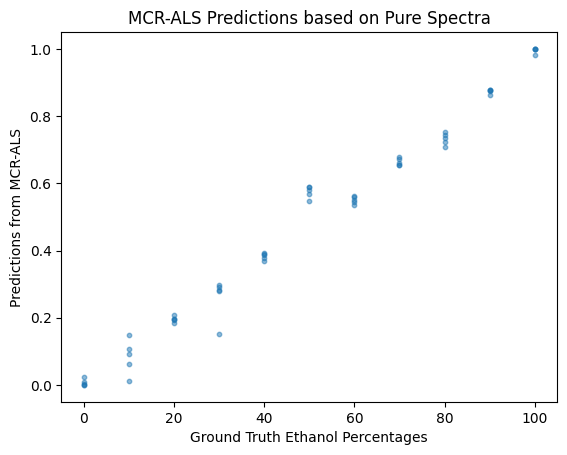

In [8]:
# I think its random whjch axis in C_opt_ gets which concentration
plt.scatter(x=C[:, 0], y=mcrar.C_opt_[:, 1], s=10, alpha=0.5)
plt.ylabel("Predictions from MCR-ALS")
plt.xlabel("Ground Truth Ethanol Percentages")
plt.title("MCR-ALS Predictions based on Pure Spectra")

## Predicting Pure Spectra from Concentration data

In [9]:
mcrar = McrAR(
    max_iter=100,
    st_regr="NNLS",
    c_regr="OLS",
    c_constraints=[ConstraintNonneg(), ConstraintNorm()],
)
mcrar.fit(D=D[5:-5, :], C=C[5:-5, :] / 100, verbose=True)

Iter: 1 (ST)	mse: 1.2719e-04
Iter: 2 (C)	mse: 1.0952e-04
Iter: 2 (ST)	mse: 1.0901e-04
Iter: 3 (C)	mse: 1.0889e-04
Iter: 3 (ST)	mse: 1.0888e-04
Iter: 4 (C)	mse: 1.0886e-04
Iter: 4 (ST)	mse: 1.0885e-04
Iter: 5 (C)	mse: 1.0884e-04
Iter: 5 (ST)	mse: 1.0883e-04
Iter: 6 (C)	mse: 1.0882e-04
Iter: 6 (ST)	mse: 1.0882e-04
Iter: 7 (C)	mse: 1.0881e-04
Iter: 7 (ST)	mse: 1.0880e-04
Iter: 8 (C)	mse: 1.0879e-04
Iter: 8 (ST)	mse: 1.0879e-04
Iter: 9 (C)	mse: 1.0878e-04
Iter: 9 (ST)	mse: 1.0878e-04
Iter: 10 (C)	mse: 1.0878e-04
Iter: 10 (ST)	mse: 1.0877e-04
Iter: 11 (C)	mse: 1.0877e-04
Iter: 11 (ST)	mse: 1.0876e-04
Iter: 12 (C)	mse: 1.0876e-04
Iter: 12 (ST)	mse: 1.0876e-04
Iter: 13 (C)	mse: 1.0876e-04
Iter: 13 (ST)	mse: 1.0875e-04
Iter: 14 (C)	mse: 1.0875e-04
Iter: 14 (ST)	mse: 1.0875e-04
Iter: 15 (C)	mse: 1.0875e-04
Iter: 15 (ST)	mse: 1.0875e-04
Iter: 16 (C)	mse: 1.0874e-04
Iter: 16 (ST)	mse: 1.0874e-04
Iter: 17 (C)	mse: 1.0874e-04
Iter: 17 (ST)	mse: 1.0874e-04
Iter: 18 (C)	mse: 1.0874e-04
Iter: 18 (ST)	

Text(0.5, 0, 'Wavelength (nm)')

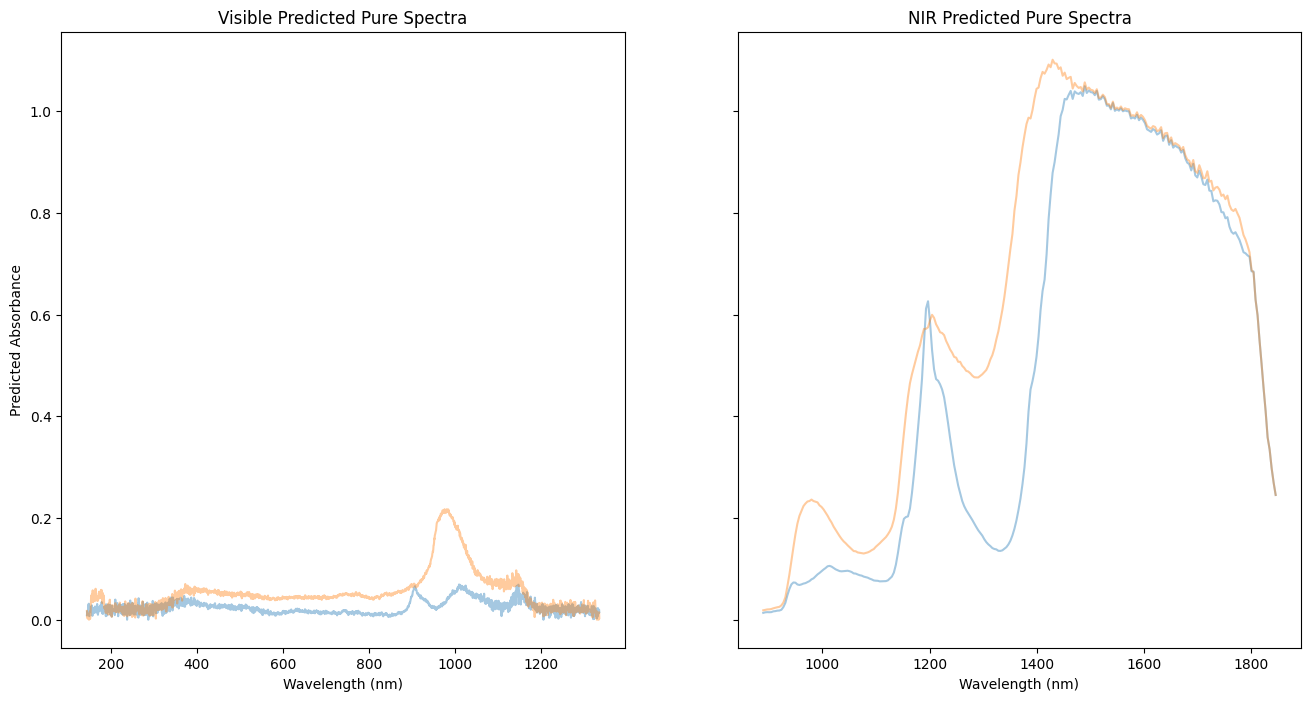

In [10]:
vis_cols = [
    float(col.split("_")[1]) for col in wavelengths if "avaspec" in col
]
nir_cols = [
    float(col.split("_")[1]) for col in wavelengths if "hamamatsu" in col
]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), sharey=True)

ax[0].plot(
    vis_cols,
    mcrar.ST_opt_[0, :2048],
    alpha=0.4,
)
ax[0].plot(
    vis_cols,
    mcrar.ST_opt_[1, :2048],
    alpha=0.4,
)

ax[1].plot(
    nir_cols,
    mcrar.ST_opt_[0, 2048:],
    alpha=0.4,
)
ax[1].plot(
    nir_cols,
    mcrar.ST_opt_[1, 2048:],
    alpha=0.4,
)

ax[1].set_title("NIR Predicted Pure Spectra")
ax[0].set_title("Visible Predicted Pure Spectra")
ax[0].set_ylabel("Predicted Absorbance")
ax[0].set_xlabel("Wavelength (nm)")
ax[1].set_xlabel("Wavelength (nm)")

In [11]:
with open("./lsq.npz", "wb") as lsq_output:
    np.savez(lsq_output, lsq_st=mcrar.ST_opt_)